# Cell specific $\alpha$ and $\beta$ (based on the ICSP)  inference and visualization by heat map.

In [1]:
import warnings

warnings.filterwarnings('ignore')

import dynamo as dyn

## Load and preprocess the data

The analysis is based on the cell cycle dataset. To run analysis on your own data, read your fileto an AnnData object with adata = dyn.read('file name'). 

In [2]:
filename = './data/rpe1.h5ad'

rpe1 = dyn.read(filename)

dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

rpe1.obs.exp_type.value_counts()

rpe1[rpe1.obs.exp_type == 'Chase', :].obs.time.value_counts()

rpe1[rpe1.obs.exp_type == 'Pulse', :].obs.time.value_counts()

rpe1_kinetics = rpe1[rpe1.obs.exp_type == 'Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]


rpe1_kinetics.obs.time = rpe1_kinetics.obs.time.astype('float')
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time / 60  # convert minutes to hours

In [3]:
# Set est_method='CSP4ML_ICSP'
dyn.tl.recipe_kin_data(adata=rpe1_kinetics,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=True,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='CSP4ML_ICSP',
                       )

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate slope k via linear regression.: 1000it [00:01, 706.89it/s]
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 603.08it/s]
Estimate gamma via maximum likelihood estimation based on the ICSP model : 1000it [00:04, 215.67it/s]
Estimate cell specific alpha and beta: 1000it [08:12,  2.03it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [13.3111s]
|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [4.5791s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embeddin

AnnData object with n_obs × n_vars = 2793 × 11402
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'sl_Size_Factor', 'initial_sl_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'uu_Size_Factor', 'initial_uu_cell_size', 'su_Size_Factor', 'initial_su_cell_size', 'ul_Size_Factor', 'initial_ul_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Gene_Id', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_b', 'gamma_k', 'g

## Visualize cell-specific $\alpha$ and $\beta$ using heat map

Change the matplotlib settings for better visualization:

In [4]:
import scvelo as scv
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '12'
dpi = 600
figsize = (6, 3)

well_fitted = rpe1_kinetics.var['gamma_r2'] > 0
well_fitted_genes = well_fitted[well_fitted].index
# well_fitted_genes = rpe1_kinetics.var['gamma_r2'].sort_values(ascending=False).index[:400]
save_path = './cell_wise_figures/icsp_beta.png'

Well-fitted genes were selected by goodness of fit index:

In [5]:
well_fitted = rpe1_kinetics.var['gamma_r2'] > 0
well_fitted_genes = well_fitted[well_fitted].index
# well_fitted_genes = rpe1_kinetics.var['gamma_r2'].sort_values(ascending=False).index[:400]

Calling scv.pl.heatmap to plot cell-specific $\alpha$ and $\beta$ heat map:

ValueError: 'bboxes' cannot be empty

<Figure size 432x216 with 5 Axes>

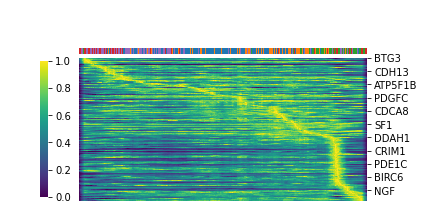

In [6]:
# cell specific beta 
save_path = './cell_wise_figures/icsp_beta.png'
ax = scv.pl.heatmap(rpe1_kinetics,
                    var_names=well_fitted_genes,
                    sortby='Cell_cycle_relativePos',
                    col_color='cell_cycle_phase',
                    n_convolve=100,
                    layer='cell_wise_beta',
                    figsize=(6, 3),
                    show=False,
                    colorbar=True,
                    cbar_pos=(0.12, 0.4, 0.05, 0.18)
                    # yticklabels=yticklabels
                    )
ax.ax_cbar.set_position([0.1, 0.07, 0.02, 0.63])
# plt.savefig(save_path, dpi=dpi, figsize=figsize)
plt.show()

ValueError: 'bboxes' cannot be empty

<Figure size 432x216 with 5 Axes>

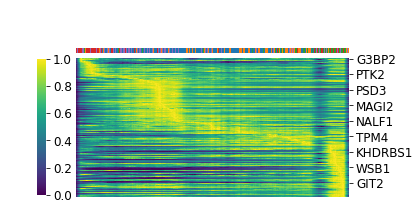

In [7]:
# cell specific alpha
save_path = './cell_wise_figures/icsp_alpha.png'
ax = scv.pl.heatmap(rpe1_kinetics,
                    var_names=well_fitted_genes,
                    sortby='Cell_cycle_relativePos',
                    col_color='cell_cycle_phase',
                    n_convolve=100,
                    layer='cell_wise_alpha',
                    figsize=(6, 3),
                    show=False,
                    colorbar=True,
                    cbar_pos=(0.12, 0.4, 0.05, 0.18)
                    # yticklabels=yticklabels
                    )
ax.ax_cbar.set_position([0.1, 0.07, 0.02, 0.63])
# plt.savefig(save_path, dpi=dpi, figsize=figsize)
plt.show()